# COVID-19
> "Covid 19 graphs and stats"
- toc: true
- branch: master
- tags: [analysis]
- hide: false
- search_exclude: true
- show_tags: true

In [1]:
# hide

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import datetime as dt
import lxml
import math
import requests
import pytz
import plotly.express as px
from IPython.display import HTML, Markdown as md
sns.set_style('darkgrid')

In [2]:
# hide

# data source
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_c = pd.read_csv(url_confirmed)
df_d = pd.read_csv(url_deaths)
df_r = pd.read_csv(url_recovered)

In [3]:
# hide

countries = sorted(['Italy','US','Germany','Spain', 'UK', 'Poland', 'Israel', 'World','France'])

# google 2019
population = {'Italy':60.36*10**6, 'US':328.2*10**6, 
              'Germany':83.02*10**6 , 'Spain':46.94*10**6,
              "UK":66.65*10**6, 'Poland':37.97*10**6, 
              'France':66.99*10**6,
              'Israel':8.884*10**6}

countries_without_world = sorted(list(set(countries)-set(['World'])))
# sorted(['Italy','US','Germany','Spain', 'UK', 'Poland', 'Israel'])

def start(df):
    return df.copy()

def add_world(df):
    world = df.sum(axis=0)
    df.loc[len(df)] = world
    df.loc[len(df)-1,'Country/Region'] = 'World'
    return df

def clean(df):
    df = df.rename(columns={'Country/Region':'country', 'Province/State':'state'})
    # keep uk as uk
    to_drop = df[(df['country']=='United Kingdom') & (~df['state'].isna())].index
    df = df.drop(index=to_drop)
    df.loc[df['country']=='United Kingdom','country'] = 'UK'
    df.loc[df['country']=='Korea, South','country'] = 'South Korea'
    return df

def group_and_stack(df):
    date_columns = list(set(df.columns) - set(['country', 'state','Lat','Long']))
    df_stack = (df.groupby(['country'])[date_columns].sum().stack()
                    .reset_index().rename(columns={'level_1':'date',0:'count'})).copy()
    df_stack['count'] = df_stack['count'].astype(int)
    return df_stack

def convert_date(df, format='%m/%d/%y'):
    df['date'] = pd.to_datetime(df['date'],format=format)
    return df.sort_values(by=['country','date'])

def add_daily_change(df):
    df['daily_change']=df.groupby(['country'])['count'].diff()
    df['daily_percent_change'] = df['daily_change']/df['count'].shift(1)*100
    df.loc[df[df['daily_percent_change']==np.inf].index,'daily_percent_change']=0
    df = df.fillna(0)
    return df

def limit_countries(df):
    df = df[df['country'].isin(countries)]
    return df

def add_days_from_100_confirmed(df):
    df['days'] = 1
    df['days'] = df.groupby('country')['days'].cumsum()-1
    
    for country in df['country'].unique():
        more_than_100 = df[(df['count']>=100) & (df['country']==country)]
        if len(more_than_100) > 0:
            dd = more_than_100.iloc[[0]]['days'].values[0]
            df.loc[df[df['country']==country].index, 'days_from_100']=\
                df.loc[df[df['country']==country].index, 'days'] - dd
        else:
            df.loc[df[df['country']==country].index, 'days_from_100'] = 0
    return df

def add_days_from_10_dead(df):
    df['days'] = 1
    df['days'] = df.groupby(['country'])['days'].cumsum()-1
    df['days_from_10'] = 0
    for country in df['country'].unique():
        more_than_10 = df[(df['count']>=10) & (df['country']==country)]
        if len(more_than_10) > 0:
            dd = more_than_10.iloc[[0]]['days'].values[0]
            df.loc[df[df['country']==country].index, 'days_from_10']=\
                df.loc[df[df['country']==country].index, 'days'] - dd
    return df

In [4]:
# hide

df_confirmed = (df_c.pipe(start)
                    .pipe(add_world)                
                    .pipe(clean)
                    .pipe(group_and_stack)
                    .pipe(convert_date)
                    .pipe(add_daily_change)
                    .pipe(limit_countries)
                    .pipe(add_days_from_100_confirmed))

df_confirmed_all = (df_c.pipe(start)
                    .pipe(add_world)                
                    .pipe(clean)
                    .pipe(group_and_stack)
                    .pipe(convert_date)
                    .pipe(add_daily_change)
                    .pipe(add_days_from_100_confirmed))

df_recovered = (df_r.pipe(start)
                    .pipe(add_world)                
                    .pipe(clean)
                    .pipe(group_and_stack)
                    .pipe(convert_date, format='%m/%d/%y')
                    .pipe(add_daily_change)
                    .pipe(limit_countries))

df_death = (df_d.pipe(start)
                    .pipe(add_world)                
                    .pipe(clean)
                    .pipe(group_and_stack)
                    .pipe(convert_date)
                    .pipe(add_daily_change)
                    .pipe(limit_countries)
                    .pipe(add_days_from_10_dead))

df_death_all = (df_d.pipe(start)
                    .pipe(add_world)                
                    .pipe(clean)
                    .pipe(group_and_stack)
                    .pipe(convert_date)
                    .pipe(add_daily_change)
                    .pipe(add_days_from_10_dead))

/var/folders/qs/tk6x68b13d30vs5f9ggc4crm0000gn/T/ipykernel_31512/3813125778.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  world = df.sum(axis=0)


In [5]:
# hide_input
date = df_confirmed['date'].max().date()
weekday_map = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
day_of_week = weekday_map[date.weekday()]
md(f"""Last Updated: {day_of_week}, {date} <br>""")

Last Updated: Wednesday, 2021-12-08 <br>

Data Source: 2019 Novel Coronavirus COVID-19 (2019-nCoV) 
[Data Repository](https://github.com/CSSEGISandData/COVID-19) by Johns Hopkins CSSE.

## Cases by country

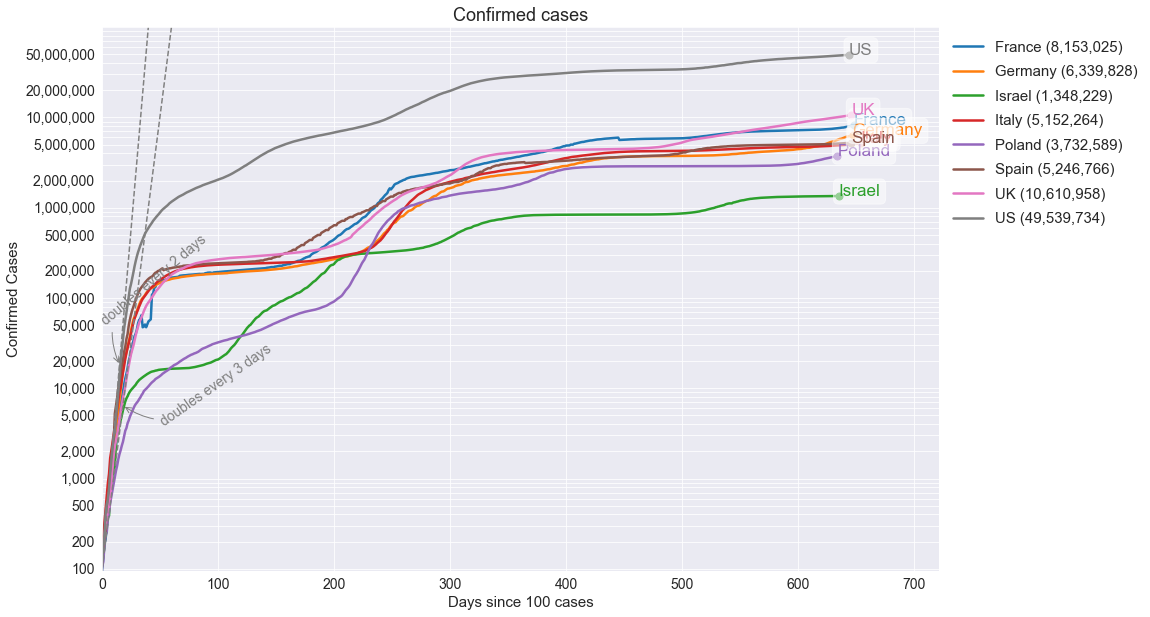

In [6]:
# hide_input

df_no_world = df_confirmed[df_confirmed['country'].isin(countries_without_world)].copy()

days = (dt.datetime.now().date()
        - df_no_world[df_no_world['days_from_100']>0]['date'].dt.date.min()).days+2

x = np.arange(0,1.1*days)
def exp_growth(x, days_to_double=3):
    return 100*(2**(1/days_to_double))**x

max_count = df_no_world['count'].max()

fig,ax=plt.subplots(figsize=(15,10))

sns.lineplot(data=df_no_world,
             x='days_from_100', 
             y='count', 
             hue='country', linewidth=2.5)

ax.plot(x, exp_growth(x,3), linestyle='--',color='gray')
ax.plot(x, exp_growth(x,2), linestyle='--',color='gray')

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.tick_params(axis='both', labelsize=14);
ax.set_ylabel('Confirmed Cases', fontsize=15);
ax.set_xlabel('Days since 100 cases', fontsize=15)

labels = [f"""{country} ({format(df_no_world[df_no_world['country']==country].
          iloc[-1]['count'],',')})""" for country in countries_without_world]

for id, row in df_no_world.groupby(['country']).last().reset_index().iterrows():
    plt.annotate(text=row['country'], 
                 xy=(row['days_from_100'], row['count']),
                 fontsize=17, rotation=0, color=sns.color_palette()[id],
                                  bbox=dict(boxstyle="round", fc="w",alpha=0.5))

    plt.plot(row['days_from_100'], row['count'], marker='o', markersize=7,
             color=sns.color_palette()[id])
    
ax.annotate(text='doubles every 3 days', xy=(18,exp_growth(18,3)), fontsize=14, color='gray'
            ,transform=ax.transAxes,
            rotation=35, xycoords='data', xytext=(35,-20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.5",color='gray'))

ax.annotate(text='doubles every 2 days', xy=(15,exp_growth(15,2)), fontsize=14, color='gray'
            ,transform=ax.transAxes,
            rotation=40, xycoords='data', xytext=(-20,40), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.5",color='gray'))


ax.yaxis.grid(True, which='both')

base = np.array([10,20,50])
ticks=[]
for i in range(int(np.log10(max_count))):
    ticks.extend(base*10**i)

ax.set_yticks(ticks)

ylim =  10**(round(np.log10(max_count)))
if (ylim<max_count):
    ylim = 1.5*max_count

ax.set(xlim=(0,days*1.1), ylim=(95, ylim))

plt.legend(title='', loc='upper left', labels=labels, bbox_to_anchor=(1, 1), frameon=False,
           fontsize=15, scatterpoints=None,labelspacing=0.7);
plt.title("Confirmed cases",fontsize=18);

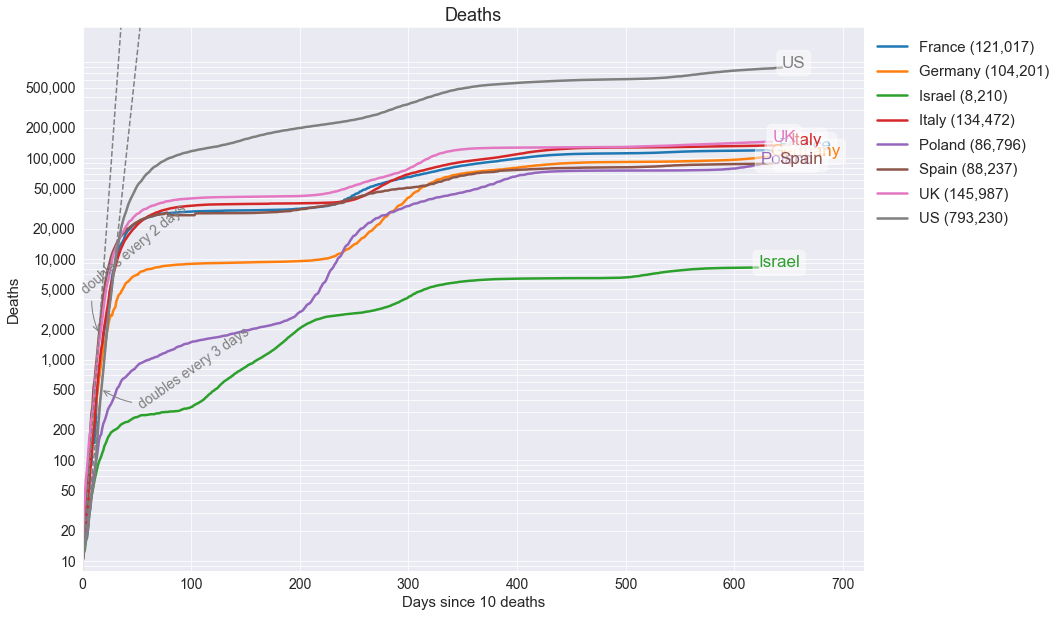

In [7]:
# hide_input

deaths_country = df_death.groupby(['country'])['count'].max().reset_index()
countries_at_least_10 = deaths_country[deaths_country['count']>10].country.values

countries_at_least_10 = [c for c in countries_at_least_10 if c != 'World']

df_no_world = df_death[(df_death['country'].isin(countries_at_least_10))].copy()

days = (dt.datetime.now().date()
        - df_no_world[df_no_world['days_from_10']>0]['date'].dt.date.min()).days+2

x = np.arange(0,1.1*days)
def exp_growth(x, days_to_double=3):
    """
    exponential growth with doubling after days_to_double
    """
    return 10*(2**(1/days_to_double))**x

max_count = df_no_world['count'].max()

fig,ax=plt.subplots(figsize=(14,10))

sns.lineplot(data=df_no_world,
             x='days_from_10', 
             y='count', 
             hue='country',linewidth=2.5)

ax.plot(x, exp_growth(x,2), linestyle='--',color='gray')
ax.plot(x, exp_growth(x,3), linestyle='--',color='gray')

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set(xlim=(0,days*1.1), ylim=(8, 10**(1.05*round(np.log10(max_count)))))
ax.tick_params(axis='both', labelsize=14);
ax.set_ylabel('Deaths', fontsize=15);
ax.set_xlabel('Days since 10 deaths', fontsize=15)

labels = [f"""{country} ({format(df_no_world[df_no_world['country']==country].
          iloc[-1]['count'],',')})""" for country in countries_at_least_10]

for id, row in df_no_world.groupby(['country']).last().reset_index().iterrows():
    plt.annotate(text=row['country'], 
                 xy=(row['days_from_10'], row['count']),
                 fontsize=17, rotation=0, color=sns.color_palette()[id],
                    bbox=dict(boxstyle="round", fc="w",alpha=0.5))

    plt.plot(row['days_from_10'], row['count'],  markersize=7,
             color=sns.color_palette()[id])
        
ax.annotate(text='doubles every 3 days', xy=(17,exp_growth(17,3)), fontsize=14, color='gray'
            ,transform=ax.transAxes,
            rotation=35, xycoords='data', xytext=(35,-20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.5",color='gray'))

ax.annotate(text='doubles every 2 days', xy=(15,exp_growth(15,2)), fontsize=14, color='gray'
            ,transform=ax.transAxes,
            rotation=40, xycoords='data', xytext=(-20,40), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.5",color='gray'))


ax.yaxis.grid(True, which='both')

base = np.array([10,20,50])
ticks=[]
for i in range(int(np.log10(max_count))):
    ticks.extend(base*10**i)

ax.set_yticks(ticks)

plt.legend(title='', loc='upper left', labels=labels, bbox_to_anchor=(1, 1), frameon=False,
           fontsize=15, scatterpoints=None,labelspacing=0.7);
plt.title("Deaths",fontsize=18);

## Cases in the past week

In [8]:
# hide_input

i=-1
new_countries = countries + ['China']
cm = plt.get_cmap('Paired')
max_tot = 0
max_days = 0

df_list = []
for c in sorted(new_countries):
    if c not in ['China','World']:
        i = i+1
        df_country = df_confirmed_all[df_confirmed_all['country']==c].copy()
        rolling_week = df_country.set_index('date').rolling('7d')['daily_change']\
        .sum().reset_index(name='total')
        merged = pd.merge(rolling_week, df_country, on='date')
        df_list.append(merged)
        if merged['days_from_100'].max() > max_days:
            max_days = merged['days_from_100'].max()        

cases_df = pd.concat(df_list)
fig = px.line(cases_df, x="days_from_100", y="total", color="country", log_y=True, 
              color_discrete_sequence=px.colors.qualitative.Set1, 
              labels=dict(days_from_100='Days since 100 cases', total='New cases in the past week', country='Country'))
fig.update_xaxes(range=[0, 1.05*max_days])
fig.update_yaxes(dict(range=[2, 6.5], tickformat= "f"))

for c in sorted(new_countries):
    if c not in ['China','World']:        
        fig.add_annotation(
                    x=cases_df.loc[cases_df['country']==c,'days_from_100'].iloc[-1]+1,
                    y=np.log10(cases_df.loc[cases_df['country']==c,'total'].iloc[-1]),
                    xref="x",
                    yref="y",
                    text=c,
                    showarrow=False,
                    bgcolor="white",
                    opacity=0.5
        )
        
HTML(fig.to_html())

## Deaths in past week

In [9]:
# hide_input

i=-1
new_countries = countries + ['China']
cm = plt.get_cmap('Paired')
max_tot = 0
max_days = 0

df_list = []
for c in sorted(new_countries):
    if c not in ['China','World']:
        i = i+1
        df_country = df_death_all[df_death_all['country']==c].copy()
        rolling_week = df_country.set_index('date').rolling('7d')['daily_change']\
        .sum().reset_index(name='total')
        merged = pd.merge(rolling_week, df_country, on='date')
        df_list.append(merged)
        if merged['days_from_10'].max() > max_days:
            max_days = merged['days_from_10'].max()        

cases_df = pd.concat(df_list)
fig = px.line(cases_df, x="days_from_10", y="total", color="country", log_y=True, 
              color_discrete_sequence=px.colors.qualitative.Set1, 
              labels=dict(days_from_10='Days since 10 deaths', total='New deaths in the past week', country='Country'))
fig.update_xaxes(range=[0, 1.05*max_days])
fig.update_yaxes(dict(range=[1, 4.5], tickformat= "f"))

for c in sorted(new_countries):
    if c not in ['China','World']:        
        fig.add_annotation(
                    x=cases_df.loc[cases_df['country']==c,'days_from_10'].iloc[-1]+1,
                    y=np.log10(cases_df.loc[cases_df['country']==c,'total'].iloc[-1]),
                    xref="x",
                    yref="y",
                    text=c,
                    showarrow=False,
                    bgcolor="white",
                    opacity=0.5
        )
        
HTML(fig.to_html())

## Cases by country per million

At the beginning of a pandemic, during the exponential growth, 
the rate of spread is independent of the size of the population, and therefore
using the absolute numbers does have a meaning for understanding the spread of the virus.
At later stages however, to have a better comparison of countries and their efforts to stop the virus spreading, we need to normalize the number by the population size.

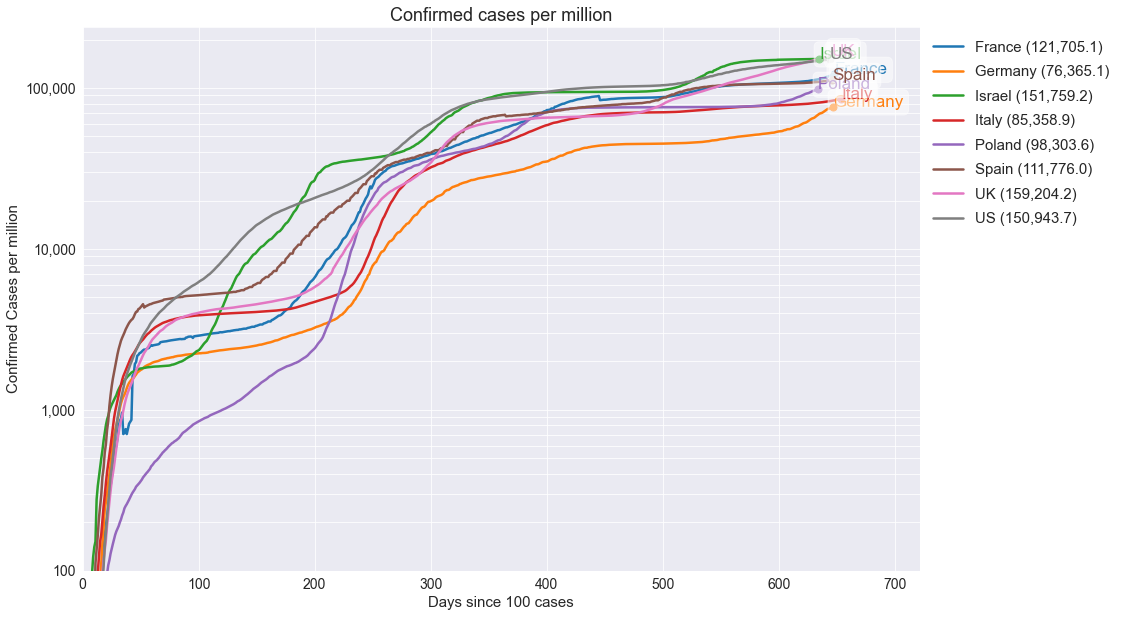

In [10]:
# hide_input

df_no_world = df_confirmed[df_confirmed['country'].isin(countries_without_world)].copy()

days = (dt.datetime.now().date()
        - df_no_world[df_no_world['days_from_100']>0]['date'].dt.date.min()).days+2

x = np.arange(0,1.1*days)

max_count = df_no_world['count'].max()

fig,ax=plt.subplots(figsize=(15,10))

df_no_world['per_million'] = df_no_world.apply(lambda x: x['count']/population[x['country']]*10**6, axis=1)

sns.lineplot(data=df_no_world,
             x='days_from_100', 
             y='per_million', 
             hue='country', linewidth=2.5)

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.tick_params(axis='both', labelsize=14);
ax.set_ylabel('Confirmed Cases per million', fontsize=15);
ax.set_xlabel('Days since 100 cases', fontsize=15)

labels = [f"""{country} ({format(round(df_no_world[df_no_world['country']==country].
          iloc[-1]['per_million'],1),',')})""" for country in countries_without_world]

for id, row in df_no_world.groupby(['country']).last().reset_index().iterrows():
    plt.annotate(text=row['country'], 
                 xy=(row['days_from_100'], row['per_million']),
                 fontsize=17, rotation=0, color=sns.color_palette()[id],
                                  bbox=dict(boxstyle="round", fc="w",alpha=0.5))

    plt.plot(row['days_from_100'], row['per_million'], marker='o', markersize=7,
             color=sns.color_palette()[id])


ax.yaxis.grid(True, which='both')

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set(xlim=(0,days*1.1), ylim=(100, 1.5*df_no_world['per_million'].max()))

plt.legend(title='', loc='upper left', labels=labels, bbox_to_anchor=(1, 1), frameon=False,
           fontsize=15, scatterpoints=None,labelspacing=0.7);
plt.title("Confirmed cases per million",fontsize=18);

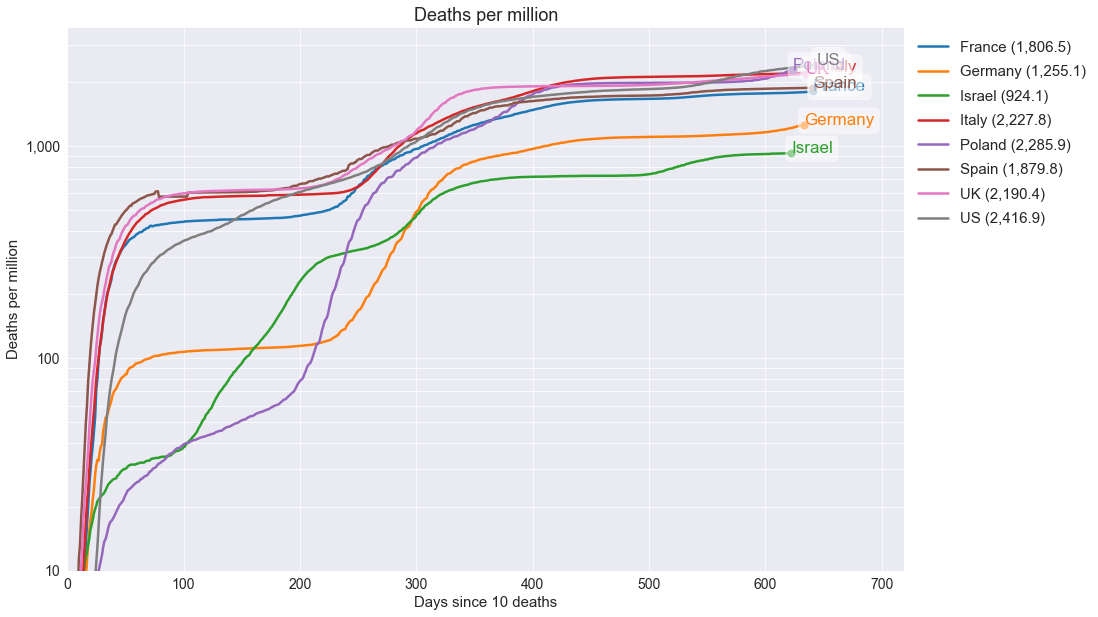

In [11]:
# hide_input

deaths_country = df_death.groupby(['country'])['count'].max().reset_index()
countries_at_least_10 = deaths_country[deaths_country['count']>10].country.values

countries_at_least_10 = [c for c in countries_at_least_10 if c != 'World']

df_no_world = df_death[(df_death['country'].isin(countries_at_least_10))].copy()

days = (dt.datetime.now().date()
        - df_no_world[df_no_world['days_from_10']>0]['date'].dt.date.min()).days+2


max_count = df_no_world['count'].max()

fig,ax=plt.subplots(figsize=(15,10))

df_no_world['per_million'] = df_no_world.apply(lambda x: x['count']/population[x['country']]*1e6, axis=1)

sns.lineplot(data=df_no_world,
             x='days_from_10', 
             y='per_million', 
             hue='country', linewidth=2.5)

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.tick_params(axis='both', labelsize=14);
ax.set_ylabel('Deaths per million', fontsize=15);
ax.set_xlabel('Days since 10 deaths', fontsize=15)

labels = [f"""{country} ({format(round(df_no_world[df_no_world['country']==country].
          iloc[-1]['per_million'],1),',')})""" for country in countries_without_world]

for id, row in df_no_world.groupby(['country']).last().reset_index().iterrows():
    plt.annotate(text=row['country'], 
                 xy=(row['days_from_10'], row['per_million']),
                 fontsize=17, rotation=0, color=sns.color_palette()[id],
                                  bbox=dict(boxstyle="round", fc="w",alpha=0.5))

    plt.plot(row['days_from_10'], row['per_million'], marker='o', markersize=7,
             color=sns.color_palette()[id])


ax.yaxis.grid(True, which='both')

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set(xlim=(0,days*1.1), ylim=(10, 1.5*df_no_world['per_million'].max()))

plt.legend(title='', loc='upper left', labels=labels, bbox_to_anchor=(1, 1), frameon=False,
           fontsize=15, scatterpoints=None,labelspacing=0.7);
plt.title("Deaths per million",fontsize=18);

## Worldwide Cases

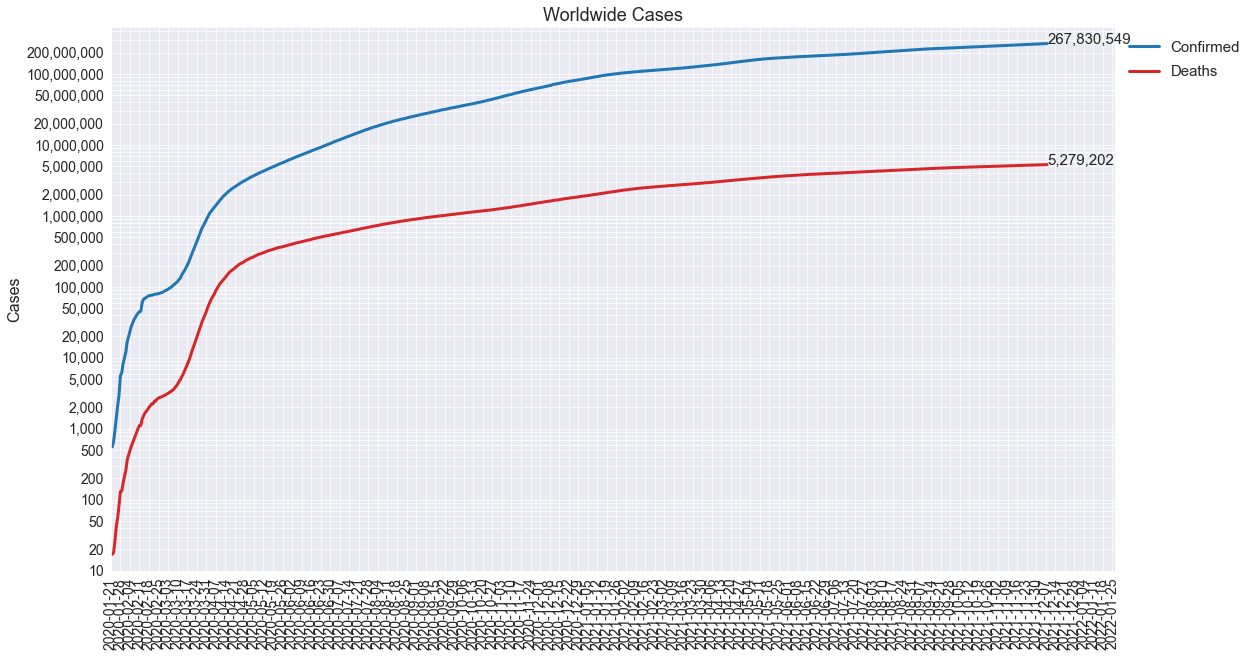

In [15]:
# hide_input

# Worldwide growth

confirmed = df_confirmed[df_confirmed['country']=="World"].iloc[-1]['count']
dead = df_death[df_death['country']=="World"].iloc[-1]['count']

last_day = df_confirmed[df_confirmed['country']=="World"].iloc[-1]['date']
first_day = df_confirmed[df_confirmed['country']=="World"].iloc[0]['date']

max_count = df_confirmed[df_confirmed['country']=="World"]['count'].max()

fig,ax=plt.subplots(figsize=(18,10))

sns.lineplot(data=df_confirmed[df_confirmed['country'] == "World"],
             x='date', y='count', ax=ax, color=sns.color_palette()[0],
            linewidth=3, markersize=7)

sns.lineplot(data=df_death[df_death['country'] == "World"],
             x='date', y='count', ax=ax, color=sns.color_palette()[3],
             linewidth=3, markersize=7)

plt.plot(df_confirmed[df_confirmed['country'] == "World"]['date'].iloc[-1], 
         df_confirmed[df_confirmed['country'] == "World"]['count'].iloc[-1], markersize=7,
         color=sns.color_palette()[0])

plt.plot(df_death[df_death['country'] == "World"]['date'].iloc[-1], 
         df_death[df_death['country'] == "World"]['count'].iloc[-1],markersize=7,
         color=sns.color_palette()[3])

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: 
                                                                   format(int(x), ',')))

ax.tick_params(axis='both', labelsize=14);
ax.tick_params(axis='x', rotation=90);
ax.set_ylabel('Cases', fontsize=16);
ax.set_xlabel('')

ax.annotate(text=format(confirmed,","), xy=(last_day + dt.timedelta(days=0.5), confirmed), fontsize=15)

ax.annotate(text=format(dead,","), xy=(last_day + dt.timedelta(days=0.5), dead), fontsize=15)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

ax.yaxis.grid(True, which='both')


base = np.array([10,20,50])
ticks=[]
for i in range(int(np.log10(max_count))):
    ticks.extend(base*10**i)

ax.set_yticks(ticks)

ylim = 10**(round(np.log10(max_count)))
if (ylim < max_count):
    ylim = 1.7*max_count

ax.set(xlim=(first_day - dt.timedelta(days=1), last_day + dt.timedelta(days=50)), ylim=(10, ylim))

labels = ["Confirmed",
          "Deaths"]
plt.legend(title='', loc='upper left', labels=labels, bbox_to_anchor=(1, 1), frameon=False,
           fontsize=15, scatterpoints=None,labelspacing=0.7);

plt.title("Worldwide Cases",fontsize=18);


In [16]:
# hide_input
md(f"## Summary table - {day_of_week}, {date}")

## Summary table - Wednesday, 2021-12-08

In [17]:
# hide_input

df_summary = (df_confirmed.groupby(['country'],as_index=False)['count']\
 .last().rename(columns={'count':'Confirmed'})\
 .merge(df_death.groupby(['country'],as_index=False)['count']\
        .last().rename(columns={'count':'Deaths'}), on='country')\
 .merge(df_confirmed.groupby(['country'],as_index=False)['daily_change'].last()\
        .rename(columns={'daily_change':'Daily confirmed'}), on='country')\
 .merge(df_death.groupby(['country'],as_index=False)['daily_change'].last()\
        .rename(columns={'daily_change':'Daily deaths'}), on='country')\
 .merge(df_confirmed.groupby(['country'],as_index=False)['daily_percent_change'].last()\
        .rename(columns={'daily_percent_change':'Daily increase (confirmed)'}), on='country')  
 .merge(df_death.groupby(['country'],as_index=False)['daily_percent_change'].last()\
        .rename(columns={'daily_percent_change':'Daily increase (deaths)'}), on='country') 
 .sort_values(by='Confirmed',ascending=False)).rename(columns={'country':'Country'})\
 .set_index('Country')

df_summary['Daily confirmed'] = df_summary['Daily confirmed'].astype(int).apply(lambda x: f"{x:,}")
df_summary['Daily deaths'] = df_summary['Daily deaths'].astype(int).apply(lambda x: f"{x:,}")
df_summary['Deaths'] = df_summary['Deaths'].astype(int).apply(lambda x: f"{x:,}")
df_summary['Confirmed'] = df_summary['Confirmed'].astype(int).apply(lambda x: f"{x:,}")
df_summary['Daily increase (confirmed)'] = df_summary['Daily increase (confirmed)']\
                                                    .apply(lambda x: f"{x:.1f}%")
df_summary['Daily increase (deaths)'] = df_summary['Daily increase (deaths)']\
                                                    .apply(lambda x: f"{x:.1f}%")

df_summary['Daily confirmed'] = df_summary.apply(lambda x: f"{x['Daily confirmed']} (+{x['Daily increase (confirmed)']})", axis=1)
df_summary['Daily deaths'] = df_summary.apply(lambda x: f"{x['Daily deaths']} (+{x['Daily increase (deaths)']})", axis=1)

df_summary[['Confirmed','Deaths','Daily confirmed','Daily deaths']]

Confirmed     Deaths  Daily confirmed   Daily deaths
Country                                                        
World    267,830,549  5,279,202  673,503 (+0.3%)  7,974 (+0.2%)
US        49,539,734    793,230  151,739 (+0.3%)  1,714 (+0.2%)
UK        10,610,958    145,987   50,617 (+0.5%)    161 (+0.1%)
France     8,153,025    121,017   61,358 (+0.8%)    134 (+0.1%)
Germany    6,339,828    104,201   27,482 (+0.4%)    150 (+0.1%)
Spain      5,246,766     88,237        0 (+0.0%)      0 (+0.0%)
Italy      5,152,264    134,472   17,946 (+0.3%)     86 (+0.1%)
Poland     3,732,589     86,796   28,549 (+0.8%)    591 (+0.7%)
Israel     1,348,229      8,210      755 (+0.1%)      0 (+0.0%)

In [18]:
# hide_input

try: 
    url = "https://www.worldometers.info/coronavirus/#countries"
    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)

    df_w = pd.read_html(r.text, header=[0], index_col=0)[0]

    df_w = df_w.set_index('Country,Other')
    df_w.index.name='Country'
    df_w = df_w.rename(index={'USA':'US'}, 
                       columns={'Tot\xa0Cases/1M pop':'Total Cases/1M pop','Tot\xa0Deaths/1M pop':'Total Deaths/1M pop'})
    # df_w = df_w.reset_index()


    df_w.rename(columns={'TotalCases':'Total Cases',
                         'NewCases':'New Cases',
                         'NewDeaths':'New Deaths',                     
                         'TotalDeaths':'Total Deaths',
                         'TotalRecovered': 'Total Recovered',
                         'ActiveCases':'Active Cases'}, inplace=True)

    df_countries = df_w.loc[countries].sort_values(by='Total Cases', ascending=False).fillna(0)

    df_countries['Total Deaths'] = df_countries['Total Deaths'].astype(int).apply(lambda x: f"{x:,}")
    df_countries['Total Cases'] = df_countries['Total Cases'].astype(int).apply(lambda x: f"{x:,}")
    # df_countries['New Deaths'] = df_countries['New Deaths'].astype(int).apply(lambda x: f"{x:,}")
    df_countries['Active Cases'] = df_countries['Active Cases'].astype(int).apply(lambda x: f"{x:,}")
    df_countries['Total Recovered'] = df_countries['Total Recovered'].astype(int).apply(lambda x: f"{x:,}")
    df_countries['Serious,Critical'] = df_countries['Serious,Critical'].astype(int).apply(lambda x: f"{x:,}")

    df_countries.loc['World','Total Cases/1M pop'] = '-'
    df_countries.loc['World','Deaths/1M pop'] = '-'

    cols = ['Total Cases', 'New Cases', 'Total Deaths', 'New Deaths', 'Total Recovered', 'Active Cases', 'Total Cases/1M pop', 'Deaths/1M pop']

    df_countries[cols]
except:
    pass

In [19]:
# hide_input

md(f"Last updated: {dt.datetime.now().replace(microsecond=0)}")

Last updated: 2021-12-09 21:46:44